## NIH Dataset VGG16 Classification for Pneumonia detection 

This notebook a code for a VGG16 based model building & training for Pneumonia xrays classification.

In [1]:
import numpy as np 
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import sklearn.model_selection as skl
from random import sample 
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics as skmetrics
from numpy import sqrt
from numpy import argmax

Using TensorFlow backend.


## Data Loading

In [2]:
## Loading data and adding a path column
df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])
df['path'] = df['Image Index'].map(all_image_paths.get)
df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
82009,00020184_011.png,Infiltration,11,20184,25,M,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00020184_011.png
78417,00019242_004.png,No Finding,4,19242,31,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00019242_004.png
101644,00027007_000.png,No Finding,0,27007,47,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00027007_000.png


## Data Cleaning

In [3]:
# The column 'Unnamed: 11' is empty, let's drop it
df = df.drop('Unnamed: 11', axis=1)

# The image resolution is not a pertinent information for pneumonia cases modeling, so let's drop the last 4 columns
df = df.drop(['OriginalImage[Width', 
                               'Height]', 
                               'OriginalImagePixelSpacing[x', 
                               'y]'],
                               axis=1)

# Some patients have erronous ages
err_age = df[df['Patient Age'] > 100]
err_age

# Some of the wrong ages concern patients that have several # follow-ups, 
# in those cases we replace the erronous age with an age in another follow-ups
for ind in err_age.index:
    if err_age.loc[ind]['Follow-up #'] > 0:
        df.at[ind, 'Patient Age'] = df.at[ind-1, 'Patient Age']

for ind in err_age.index:
    if df.at[ind, 'Patient ID'] == df.at[ind+1, 'Patient ID']:
        df.at[ind, 'Patient Age'] = df.at[ind+1, 'Patient Age']

# For the remaining values we will replace the age by the mean
mean_age = df['Patient Age'].mean()
for ind in err_age.index:
    df.at[ind, 'Patient Age'] = mean_age

In [4]:
# Let's do a 'hot-encoding' procedure for the categorical values of the 'Finding Labels' column to make the exploration easier
unique_findings = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
unique_findings = [x for x in unique_findings if len(x)>0]

print('All Labels ({}): {}'.format(len(unique_findings), unique_findings))
for c_label in unique_findings:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.head(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,/data/images_001/images/00000001_000.png,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,/data/images_001/images/00000001_001.png,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,/data/images_001/images/00000001_002.png,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,/data/images_001/images/00000002_000.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,/data/images_001/images/00000003_000.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,/data/images_001/images/00000003_001.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,/data/images_001/images/00000003_002.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,/data/images_001/images/00000003_003.png,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000003_004.png,Hernia,4,3,77,F,PA,/data/images_001/images/00000003_004.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000003_005.png,Hernia,5,3,78,F,PA,/data/images_001/images/00000003_005.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Splitting
We split the dataset into a training and a validation set in a 80:20 ratio.

In [5]:
train_df, test_df = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['Pneumonia'])

In [6]:
print(train_df['Pneumonia'].sum()/len(train_df))

0.012765340706386016


In [7]:
print(test_df['Pneumonia'].sum()/len(test_df))

0.012754191937210132


The pneumonia occurences in the training dataframe is really low.
We modify the dataframe to obtain a 50% proportion of pneumonia case.

In [8]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [9]:
print(len(train_df))
train_df['Pneumonia'].sum()/len(train_df)

2290


0.5

For the validation dataset we'll keep the positive:negative cases ratio low enough to be close to the original whole dataset proportions (1.3%) but sufficient to give meaningful validation results during the training. So we'll choose a p:n ratio of 1:3.

In [10]:
p_inds = test_df[test_df.Pneumonia==1].index.tolist()
np_inds = test_df[test_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,3*len(p_inds))
test_df = test_df.loc[p_inds + np_sample]

In [11]:
print(len(test_df))
test_df['Pneumonia'].sum()/len(test_df)

1144


0.25

Let's plot some xrays before data augmentation to check that everything is ok.

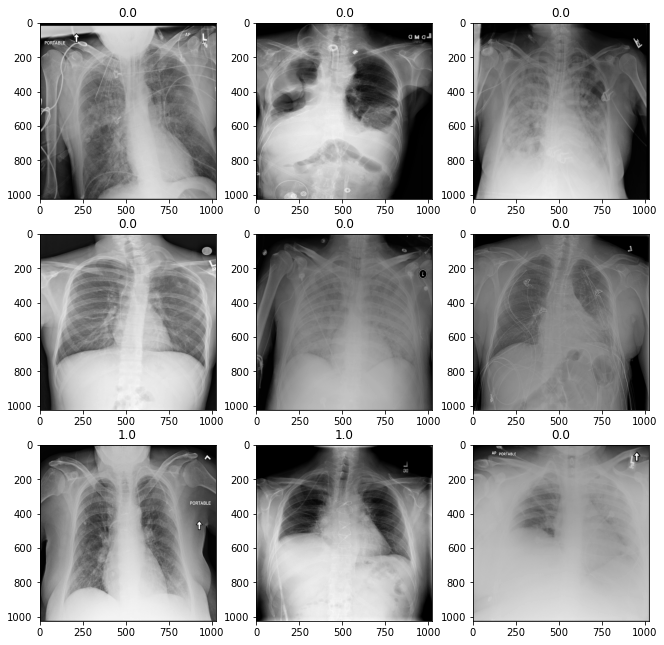

In [12]:
fig, m_axs = plt.subplots(3,3, figsize = (11, 11))
m_axs = m_axs.flatten()
imgs = train_df.path
ind=80512

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(df.iloc[ind]['Pneumonia'])
    ind=ind+1

In [18]:
# Statistics and Patient demographic data
# Notice that we will consider each xray as a different case

tnum_xrays = len(train_df)
tnum_uniq_pat = train_df['Patient ID'].nunique()
tnum_findings = len(unique_findings)
tnum_xrays_pneum = len(train_df[train_df['Pneumonia'] == 1])

tmean_age = train_df['Patient Age'].mean()
tstd_age = train_df['Patient Age'].std()
tratio_male = len(train_df[train_df['Patient Gender'] == 'M'])/tnum_xrays*100 
tratio_female = len(train_df[train_df['Patient Gender'] == 'F'])/tnum_xrays*100
tlist_viewposition = train_df['View Position'].unique()
tratio_viewpositionPA = len(train_df[train_df['View Position'] == 'PA'])/tnum_xrays*100 
tratio_viewpositionAP = len(train_df[train_df['View Position'] == 'AP'])/tnum_xrays*100 

In [19]:
print('Average of patients age :', tmean_age,"\n",
      'Standard deviation of patients age :', tstd_age,"\n",
      'Proportion of Males:', tratio_male, "%\n", 
      'Proportion of Females:', tratio_female, "%\n",
      'Proportion of PA view position:',tratio_viewpositionPA, "%\n",
      'Proportion of AP view position:',tratio_viewpositionAP, "%\n\n",)

Average of patients age : 45.63842794759825 
 Standard deviation of patients age : 17.32636657646593 
 Proportion of Males: 59.25764192139737 %
 Proportion of Females: 40.74235807860262 %
 Proportion of PA view position: 51.96506550218341 %
 Proportion of AP view position: 48.03493449781659 %




In [20]:
# Statistics and Patient demographic data
# Notice that we will consider each xray as a different case

vnum_xrays = len(test_df)
vnum_uniq_pat = test_df['Patient ID'].nunique()
vnum_findings = len(unique_findings)
vnum_xrays_pneum = len(test_df[test_df['Pneumonia'] == 1])

vmean_age = test_df['Patient Age'].mean()
vstd_age = test_df['Patient Age'].std()
vratio_male = len(test_df[test_df['Patient Gender'] == 'M'])/vnum_xrays*100 
vratio_female = len(test_df[test_df['Patient Gender'] == 'F'])/vnum_xrays*100
vlist_viewposition = test_df['View Position'].unique()
vratio_viewpositionPA = len(test_df[test_df['View Position'] == 'PA'])/vnum_xrays*100 
vratio_viewpositionAP = len(test_df[test_df['View Position'] == 'AP'])/vnum_xrays*100

In [21]:
print('Average of patients age :', vmean_age,"\n",
      'Standard deviation of patients age :', vstd_age,"\n",
      'Proportion of Males:', vratio_male, "%\n", 
      'Proportion of Females:', vratio_female, "%\n",
      'Proportion of PA view position:',vratio_viewpositionPA, "%\n",
      'Proportion of AP view position:',vratio_viewpositionAP, "%\n\n",)

Average of patients age : 46.73426573426573 
 Standard deviation of patients age : 16.691247405985532 
 Proportion of Males: 56.20629370629371 %
 Proportion of Females: 43.79370629370629 %
 Proportion of PA view position: 56.90559440559441 %
 Proportion of AP view position: 43.09440559440559 %




## Data augmentation

In [13]:
idg = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=10,
                                   horizontal_flip = True,
                                   vertical_flip = False,
                                   height_shift_range= 0.1,
                                   width_shift_range=0.1,
                                   shear_range = 0.1,
                                   zoom_range=[0.5,1.0])

train_gen = idg.flow_from_dataframe(dataframe=train_df,
                                    directory=None,
                                    x_col = 'path',
                                    y_col = 'Pneumonia',
                                    class_mode = 'raw',
                                    target_size = (224, 224),
                                    batch_size = 128,
                                    validate_filenames= False)

Found 2290 non-validated image filenames.


In [14]:
val_idg = ImageDataGenerator(rescale=1. / 255.0)

val_gen = val_idg.flow_from_dataframe(dataframe=test_df, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia',
                                              class_mode = 'raw',
                                              target_size = (224, 224),
                                              batch_size = 512,
                                              validate_filenames= False) 

Found 1144 non-validated image filenames.


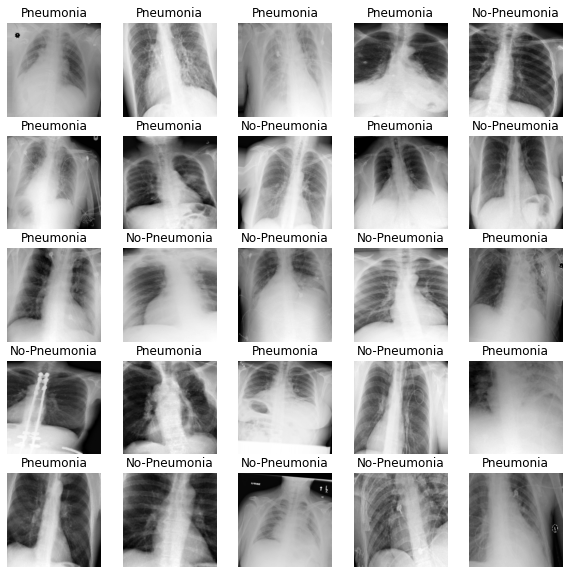

In [15]:
# Plotting some xrays from the training batch after data augmentation
t_x, t_y = next(train_gen)

fig, m_axs = plt.subplots(5, 5, figsize = (10, 10))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No-Pneumonia')
    c_ax.axis('off')

The results of data augmentation is realistic and add some variety to the dataset that may provide more flexibility to the model.

## Model Building 



In [16]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [17]:
vgg = VGG16(include_top=True, weights='imagenet')
vgg.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [18]:
transfer_layer = vgg.get_layer('block5_pool')
vgg_model = Model(inputs=vgg.input,
                   outputs=transfer_layer.output)

for layer in vgg_model.layers[0:17]:
    layer.trainable = False
    
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [19]:
new_model = Sequential()

# Customizing the last layers of the vgg16 model

new_model.add(vgg_model)
new_model.add(Flatten())
new_model.add(Dropout(0.2))
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(256, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

## Optimizer, loss function, and learning rate

optimizer = Adam(lr=0.00001)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
v_x, v_y = next(val_gen)

In [21]:
## Just run a couple of epochs before the training:
new_model.fit_generator(train_gen,
                        validation_data = (v_x, v_y),
                        epochs = 2)

Epoch 1/2
18/18 [==============================] - 73s 4s/step - loss: 0.7089 - binary_accuracy: 0.5044 - val_loss: 0.6328 - val_binary_accuracy: 0.7520
Epoch 2/2
18/18 [==============================] - 62s 3s/step - loss: 0.6976 - binary_accuracy: 0.5245 - val_loss: 0.5914 - val_binary_accuracy: 0.7539


In [21]:
# Weights saving
weight_path="{}_my_model.best.hdf5".format('xray_class')

# Saves best weights according to the value monitored
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max', 
                             save_weights_only = True)

# Stops the value monitored doesn't improve after 'patience' epochs 
early = EarlyStopping(monitor= 'binary_accuracy', 
                      mode= 'max', 
                      patience=6)

callbacks_list = [checkpoint, early]

### Training

In [22]:
new_model.load_weights(weight_path)

In [24]:
history = new_model.fit_generator(train_gen,
                        validation_data = (t_x, t_y),
                        epochs = 10, 
                        callbacks = callbacks_list)

Epoch 1/10
18/18 [==============================] - 62s 3s/step - loss: 0.5153 - binary_accuracy: 0.7410 - val_loss: 0.4982 - val_binary_accuracy: 0.7656

Epoch 00001: binary_accuracy improved from -inf to 0.74105, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
18/18 [==============================] - 61s 3s/step - loss: 0.5338 - binary_accuracy: 0.7301 - val_loss: 0.4883 - val_binary_accuracy: 0.7734

Epoch 00002: binary_accuracy did not improve from 0.74105
Epoch 3/10
18/18 [==============================] - 63s 4s/step - loss: 0.5142 - binary_accuracy: 0.7537 - val_loss: 0.4828 - val_binary_accuracy: 0.7734

Epoch 00003: binary_accuracy improved from 0.74105 to 0.75371, saving model to xray_class_my_model.best.hdf5
Epoch 4/10
18/18 [==============================] - 58s 3s/step - loss: 0.4998 - binary_accuracy: 0.7476 - val_loss: 0.4779 - val_binary_accuracy: 0.7734

Epoch 00004: binary_accuracy did not improve from 0.75371
Epoch 5/10
18/18 [==============================]

In [25]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss", color="orange")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss", color="red")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc", color="skyblue")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc", color="blue")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

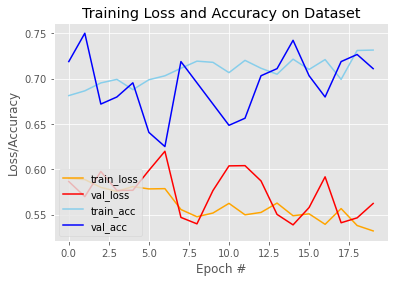

In [27]:
# ploting figures (dropout 1 = 0.5, dropout 1 = 0.5, dropout 1 = 0.5, 
# learning rate = 0.0001) after 20 training epochs

plot_history(history)

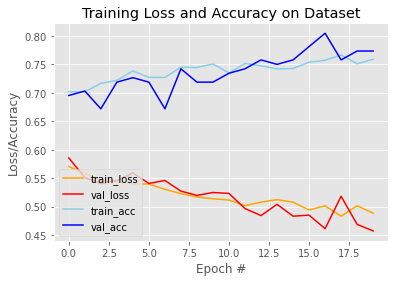

In [26]:
# ploting figures (dropout 1 = 0.2, dropout 1 = 0.2, dropout 1 = 0.2, 
# learning rate = 0.0001) after 20 training epochs

plot_history(history)

The loss starts to be more stable. Decreasing the learning rate may help to improve more but at a slower pace.

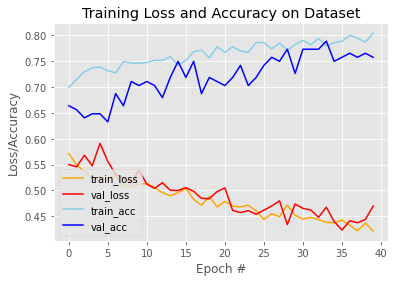

In [26]:
# ploting figures (dropout 1 = 0.2, dropout 1 = 0.2, dropout 1 = 0.2, 
# learning rate = 0.0001) after 40 training epochs

plot_history(history)

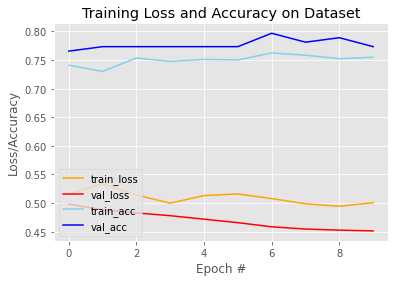

In [26]:
# ploting figures (dropout 1 = 0.2, dropout 1 = 0.2, dropout 1 = 0.2, 
# learning rate = 0.00001) after 20 training epochs

plot_history(history)

The loss did not improve. We can consider the training complete (for now).

## Model's performance assessment and threshold tuning
After building the model and training it, we can now choose a good probability threshold to convert probabilities to class (Pneumoniia/non pneumonia). Code used here comes from : https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [23]:
## Making some predictions to assess model's overall performance

new_model.load_weights(weight_path)
pred_y = new_model.predict(v_x, batch_size = 256, verbose = True)

512/512 [==============================] - 24s 47ms/step


### Sensitivity/Specificity balance (ROC curve)

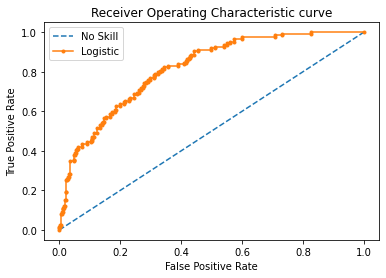

In [24]:
# calculating the true-positive rate and false-positive rate 
# for the predictions using a set of thresholds to create a ROC Curve plot.

fpr, tpr, thresholds = skmetrics.roc_curve(v_y, pred_y)  

# plotting the roc curve

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend()
plt.show()

In [25]:
# Calculating the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locating the index/threshold with the largest g-mean
# the optimal balance between false positive and true positive rates
ix = argmax(gmeans)
gmean_thresh = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.436124, G-Mean=0.736


### Precision/Recall balance 

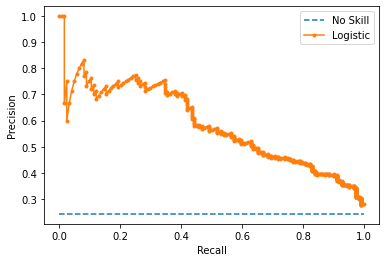

In [26]:
# Calculating pr-curve

precision, recall, thresholds = skmetrics.precision_recall_curve(v_y, pred_y)

# Plotting the pr-curve for the model

no_skill = len(v_y[v_y==1]) / len(v_y)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [27]:
# Calculating F score

fscore = (2 * precision * recall) / (precision + recall)

# Locating the index of the largest f score

ix = argmax(fscore)
f_thresh = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.436124, F-Score=0.570


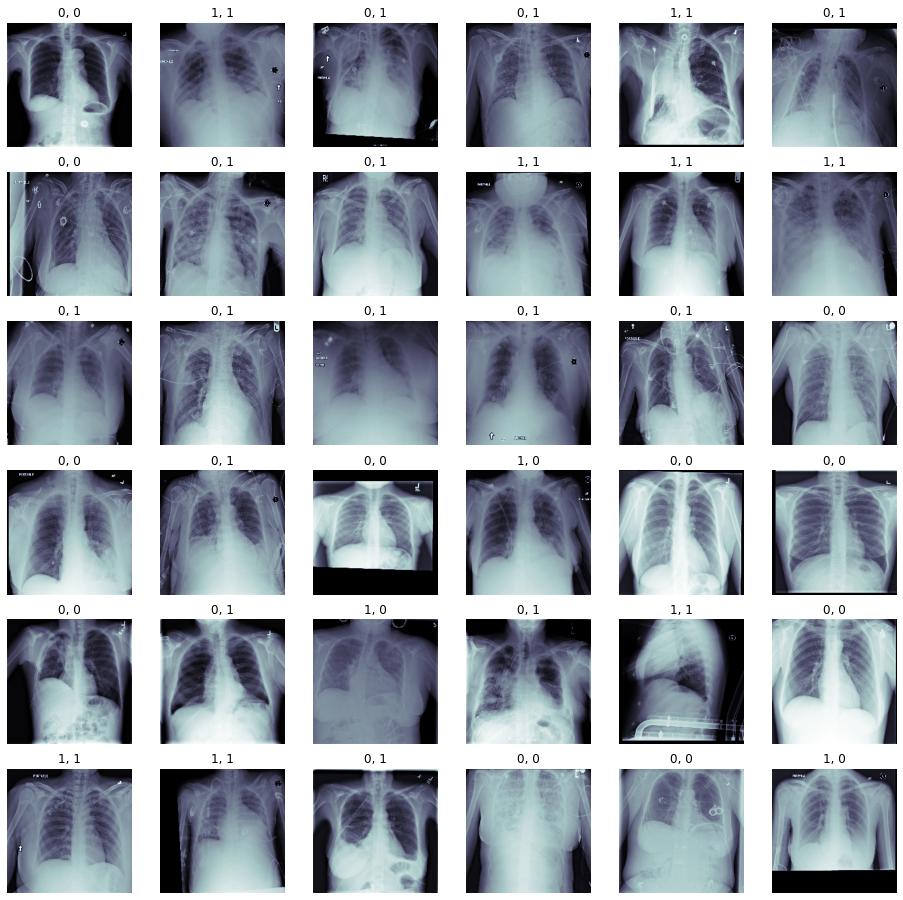

In [28]:
# Plotting some examples of true vs. predicted with the largest g-mean threshold: 

thresh = f_thresh
fig, m_axs = plt.subplots(6, 6, figsize = (16, 16))
i = 0

for (c_x, c_y, c_ax) in zip(v_x[0:36], v_y[0:36], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_y[i] > thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_y[i] > thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [29]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)